#**Simple LSTM for Sentiment Analysis (on IMDB reviews)**
by Allena Venkata Sai Abhishek(122021601009)



In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

In [3]:
dataset, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete5OA8ZU/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete5OA8ZU/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete5OA8ZU/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
for example, label in train_dataset.take(1):
  print("text: ", example.numpy())
  print("label: ", label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [6]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [7]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'I do not recommend this movie , because it\'s inaccurate and misleading, this story was supposed to be in Algerian Berber territory, this one was shot in the southern Tunisian desert, (completetly different culture, I know I am from both Tunisia and Algeria), the other shocking element was the character of her companion aunt, speaks in the movie with a very eloquent french, university level academic french while the character she plays was supposed to be of a disturbed never left her mountain kind of personage, so living as a Bedouin with that kind of education i that context is impossible, The most disgraceful scene and disrespectful especially for the people of the region is the "femme repudiee" segment which is s pure invention from the writer/director, things like that will never happen in a Algerian Society ever!!!'
 b'October Sky is a highly lauded movie, and it\xc2\xa1\xc2\xa6s easy to see why. The story is easy to comprehend and many turning points are gripping, the 

In [8]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label:text))

In [9]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [10]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[10, 82, 22, ...,  0,  0,  0],
       [ 1,  1,  7, ...,  0,  0,  0],
       [88,  5,  2, ...,  0,  0,  0]])

In [11]:
for n in range(3):
  print("original: ", example[n].numpy())
  print("round-trip: ", " ".join(vocab[encoded_example[n]]))

original:  b'I do not recommend this movie , because it\'s inaccurate and misleading, this story was supposed to be in Algerian Berber territory, this one was shot in the southern Tunisian desert, (completetly different culture, I know I am from both Tunisia and Algeria), the other shocking element was the character of her companion aunt, speaks in the movie with a very eloquent french, university level academic french while the character she plays was supposed to be of a disturbed never left her mountain kind of personage, so living as a Bedouin with that kind of education i that context is impossible, The most disgraceful scene and disrespectful especially for the people of the region is the "femme repudiee" segment which is s pure invention from the writer/director, things like that will never happen in a Algerian Society ever!!!'
round-trip:  i do not recommend this movie because its [UNK] and [UNK] this story was supposed to be in [UNK] [UNK] [UNK] this one was shot in the [UNK] [

In [12]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [13]:
history =model.fit(train_dataset, epochs=5,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/5
391/391 [==============================] - 76s 166ms/step - loss: 0.6508 - accuracy: 0.5482 - val_loss: 0.5039 - val_accuracy: 0.7635
Epoch 2/5
391/391 [==============================] - 64s 163ms/step - loss: 0.4144 - accuracy: 0.8175 - val_loss: 0.3685 - val_accuracy: 0.8365
Epoch 3/5
391/391 [==============================] - 63s 160ms/step - loss: 0.3435 - accuracy: 0.8536 - val_loss: 0.3556 - val_accuracy: 0.8443
Epoch 4/5
391/391 [==============================] - 62s 157ms/step - loss: 0.3260 - accuracy: 0.8615 - val_loss: 0.3431 - val_accuracy: 0.8495
Epoch 5/5
391/391 [==============================] - 63s 159ms/step - loss: 0.3162 - accuracy: 0.8680 - val_loss: 0.3310 - val_accuracy: 0.8547


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 101,249
Trainable params: 101,249
Non-trainable params: 0
_________________________________________________________________


In [15]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 26s 68ms/step - loss: 0.3195 - accuracy: 0.8625
Test Loss: 0.3195170760154724
Test Accuracy: 0.8625199794769287


In [16]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 0.6675026476383209)

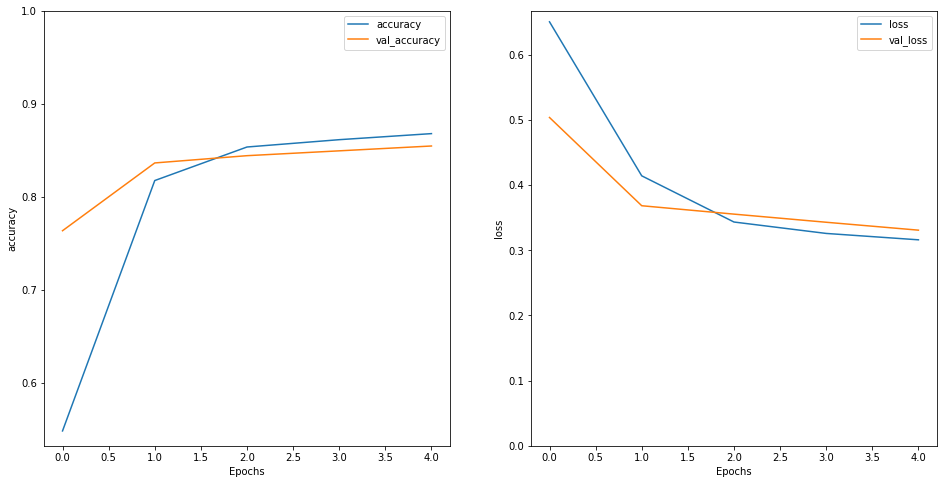

In [17]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

#@title Try the model for prediction(enter the review below to see the sentiment of the review)


In [18]:
review_text = "The movie was  good. The animation and the graphics" #@param {type:"string"}
#sample_text_1 = ('its not a good movie compared to previous one''would go for another watch')
predictions = model.predict(np.array([review_text]))
if predictions[0][0] > 0:
  print("The sentiment of the review is POSITIVE with polarity of : ",predictions[0][0])
else:
  print("The sentiment of the review is Negative with polarity of : ",predictions[0][0])

#print("The sentiment of the review is : ",predictions[0][0])

The sentiment of the review is POSITIVE with polarity of :  0.5993074
